In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import balltracking.balltrack as blt
import filters
from scipy.signal import convolve2d
from skimage.exposure import rescale_intensity
from skimage.registration import phase_cross_correlation
from scipy import ndimage
import numpy as np
import fitsio
import matplotlib.pyplot as plt

from pathlib import PurePath, Path
import glob
import multiprocessing
%matplotlib inline

Import some IBIS fits files

In [50]:
ibisdir = Path(os.environ['DATA'], 'Ben', 'IBIS', 'white_light')
ibisf = ibisdir.joinpath('ibis.wl.speckle.hmi_destr.seq1.sonicfilter.fits')

In [5]:
ibisdata = fitsio.read(str(ibisf))
ibisdata[0,...].shape

(1000, 1000)

Text(0.5, 1.0, 'original frame #4')

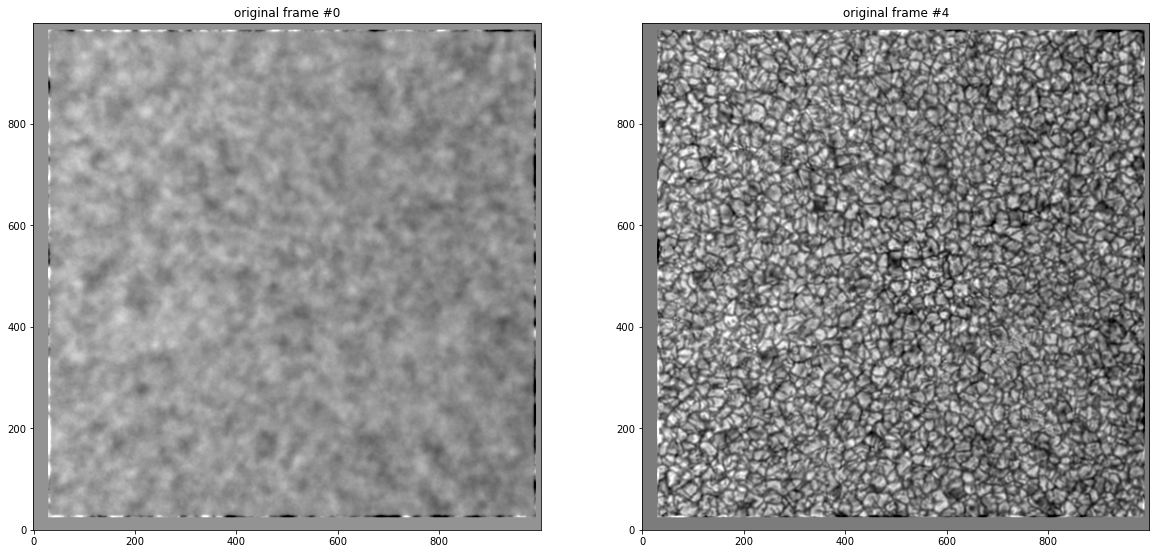

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sample1 = ibisdata[0]
plt.imshow(sample1, origin='lower', vmin=np.percentile(sample1, 0.1), vmax=np.percentile(sample1,99.9), cmap='gray')
plt.title('original frame #0')

plt.subplot(1,2,2)
start_frame = 4
sample2 = ibisdata[start_frame]
plt.imshow(sample2, origin='lower', vmin=np.percentile(sample2, 0.1), vmax=np.percentile(sample2,99.9), cmap='gray')
plt.title(f'original frame #{start_frame}')
          

Text(0.5, 1.0, 'cropped & filtered')

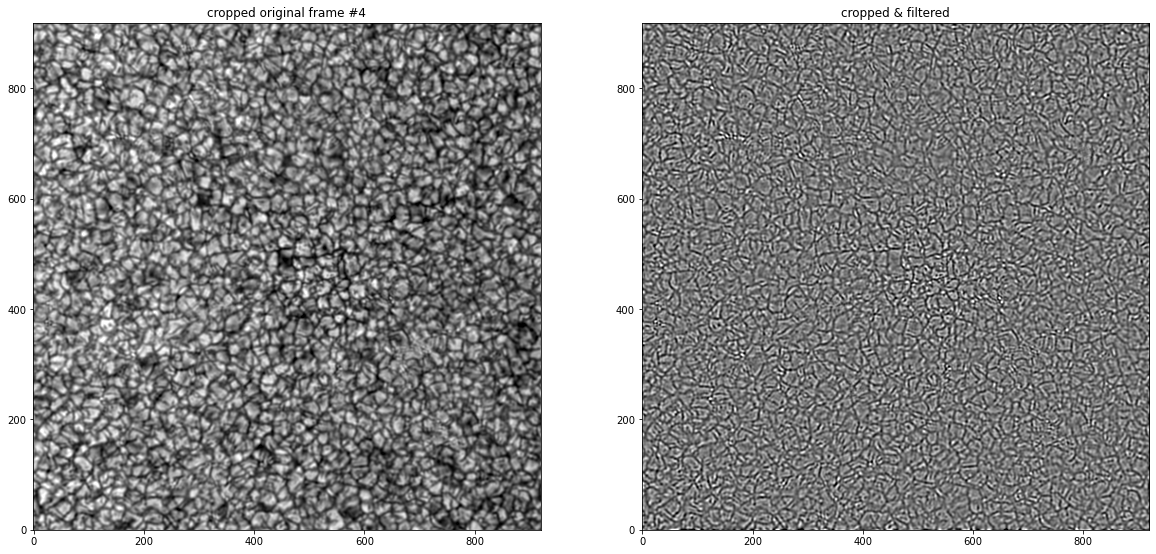

In [62]:
trim = 40
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sample2c = sample2[trim:-trim, trim:-trim]
plt.imshow(sample2c, origin='lower', vmin=np.percentile(sample2c, 0.1), vmax=np.percentile(sample2c,99.9), cmap='gray')
plt.title(f'cropped original frame #{start_frame}')
plt.subplot(1,2,2)
samplef = blt.filter_image(sample2[trim:-trim, trim:-trim], pixel_radius=10)
plt.imshow(samplef, origin='lower', vmin=np.percentile(samplef, 0.1), vmax=np.percentile(samplef,99.9), cmap='gray')
plt.title('cropped & filtered')

In [55]:
fitsio.write(ibisdir.joinpath('ibis.wl.speckle.cropped.fits'), ibisdata[4:-4, 40:-40, 40:-40])

In [29]:
radius=10
fseries = [blt.filter_image(im[trim:-trim, trim:-trim], pixel_radius=radius) for im in ibisdata]

In [76]:
# Make movie of all filtered images
# dpi = 96
# i = 4
# for i in range(len(fseries)):
#     sample = ibisdata[i, trim:-trim, trim:-trim]
#     samplef = fseries[i]
#     fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(1920/dpi, 1080/dpi), dpi=dpi)
#     axs[0].imshow(sample, origin='lower', vmin=np.percentile(sample, 0.5), vmax=np.percentile(sample,99), cmap='gray')
#     axs[0].set_xlabel('X [px]')
#     axs[0].set_ylabel('Y [px]')
#     axs[0].set_title(f'Original at [0.5 - 99] percentiles - frame #{i}')
#     axs[1].imshow(samplef, origin='lower', vmin=np.percentile(samplef, 0.5), vmax=np.percentile(samplef,99), cmap='gray')
#     axs[1].set_xlabel('X [px]')
#     axs[1].set_ylabel('Y [px]')
#     axs[1].set_title(f'Fourier 1/{radius}-px (Hanning) at [0.5 - 99] percentiles - frame #{i}')
#     plt.tight_layout()
#     plt.savefig(Path(ibisdir, 'white_light', 'jpegs', f'ibis.wl.{i}.jpeg'), dpi=dpi)
#     plt.close()

In [30]:
time_trim = 4
shifts1 = []
shifts2 = []
for i in range(time_trim, len(fseries)-time_trim):
    samplef1 = fseries[i]
    samplef2 = fseries[i+1]
    shift, error, diffphase = phase_cross_correlation(samplef1, samplef2, upsample_factor=100)
    shifts1.append(shift[0])
    shifts2.append(shift[1])

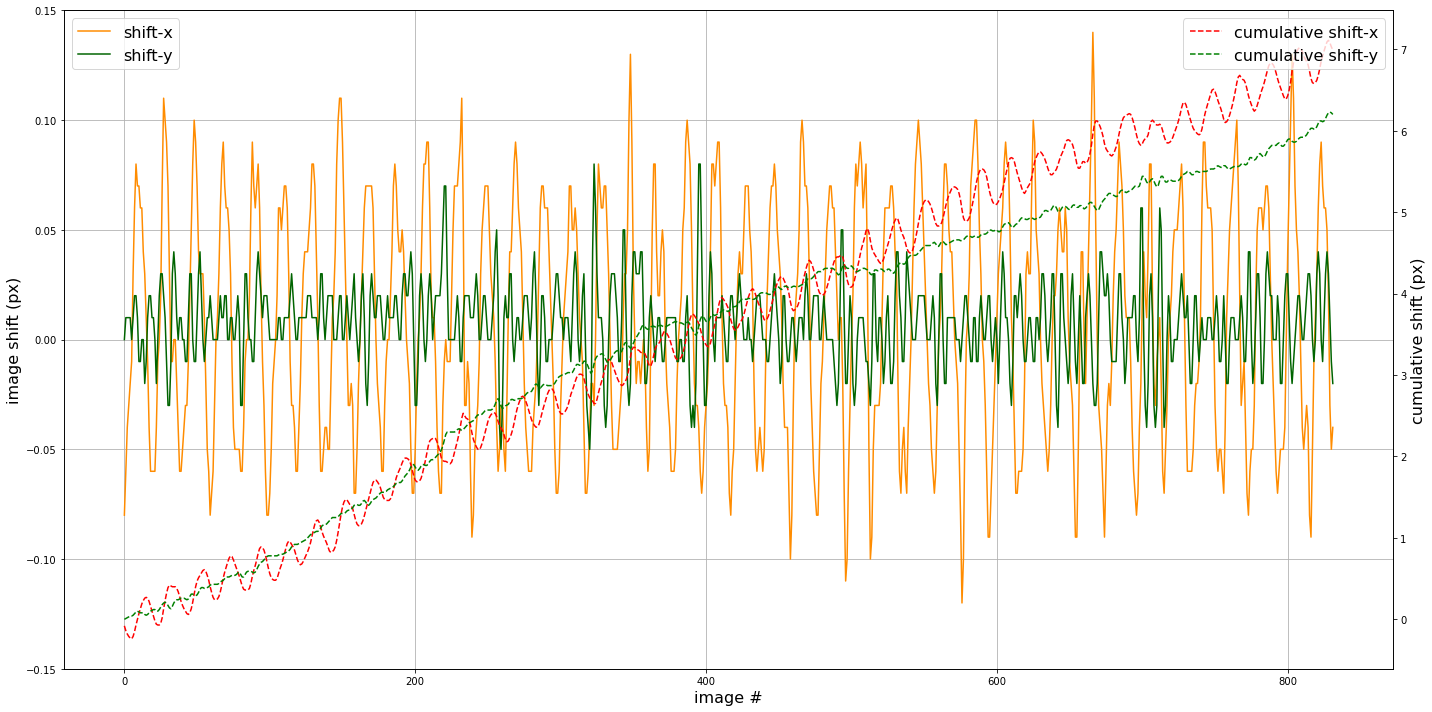

In [32]:
sum1 = np.cumsum(shifts1)
sum2 = np.cumsum(shifts2)
FS = 16
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(shifts2, label='shift-x', color='darkorange')
ax.plot(shifts1, label='shift-y', color='darkgreen')
ax.set_xlabel('image #', fontsize=FS)
ax.set_ylabel('image shift (px)', fontsize=FS)
ax.legend(fontsize=FS)
ax.set_ylim([-0.15, 0.15])
plt.grid()

ax2 = ax.twinx()
ax2.plot(sum2, ls='--', color='red', label='cumulative shift-x')
ax2.plot(sum1, ls='--', color='green', label='cumulative shift-y')
ax2.legend(fontsize=FS, loc='upper right')
ax2.set_ylabel('cumulative shift (px)', fontsize=FS)
plt.tight_layout()
plt.savefig(Path(ibisdir, f'ibis.wl.jitter.png'), facecolor='white')

### Check new registration from data_prep.py

In [38]:
ibisf2 = ibisdir.joinpath('ibis.wl.speckle.jitter_corrected.fits')
ibisdata2 = fitsio.read(str(ibisf2))
ibisdata2[0,...].shape

(920, 920)

In [1]:
def filter_image(i):
    imagef = blt.filter_image(ibisdata2[i], pixel_radius = radius)
    return imagef

def get_shift_image(i):
    samplef1 = fseries2[i]
    samplef2 = fseries2[i+1]
    shift, error, diffphase = phase_cross_correlation(samplef1, samplef2, upsample_factor=100)
    return shift

In [40]:
# fseries2 = [blt.filter_image(im, pixel_radius=radius) for im in ibisdata2]
with multiprocessing.Pool(processes=30) as pool:
    fseries2 = pool.map(filter_image, range(len(ibisdata2)))

In [41]:
with multiprocessing.Pool(processes=20) as pool:
    rshifts = pool.map(get_shift_image, range(len(fseries2)-1))
    
rshifts1, rshifts2 = zip(*rshifts)

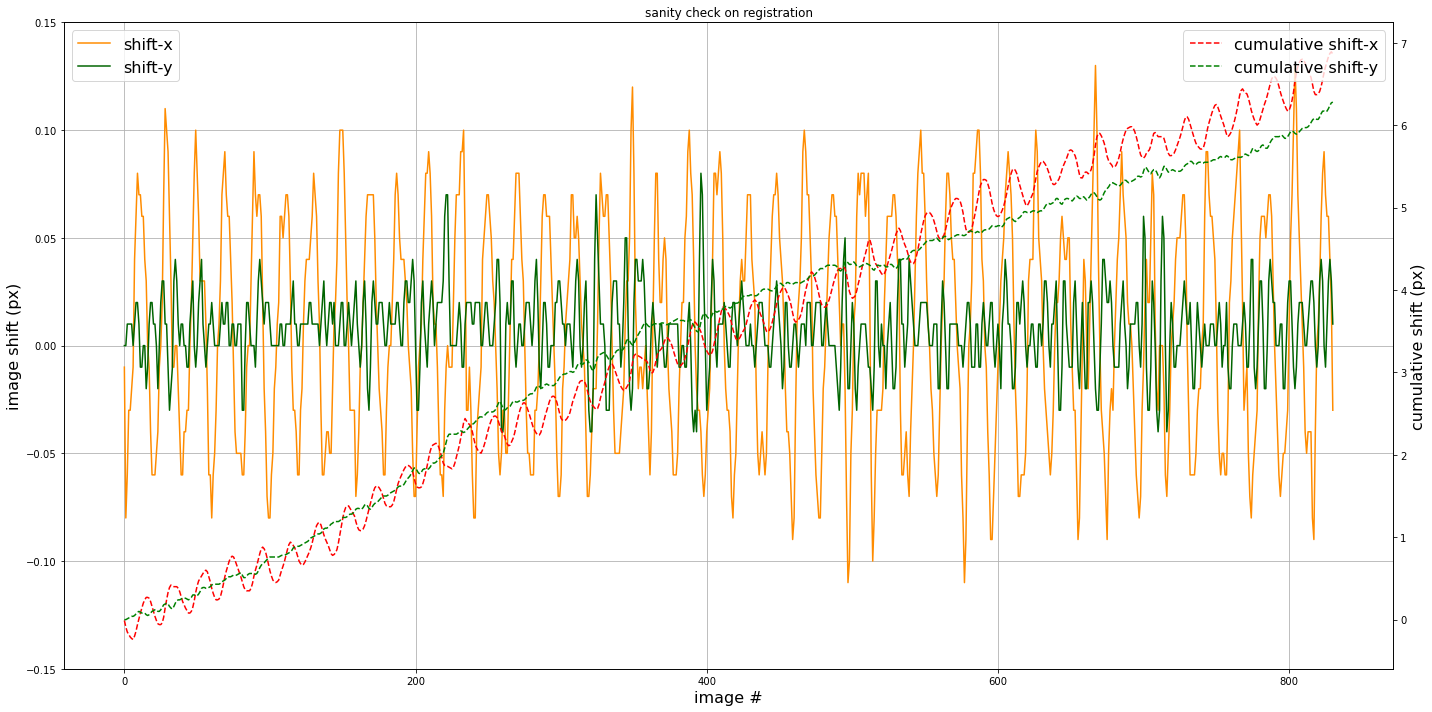

In [46]:
sum1 = np.cumsum(rshifts1)
sum2 = np.cumsum(rshifts2)
FS = 16
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(rshifts2, label='shift-x', color='darkorange')
ax.plot(rshifts1, label='shift-y', color='darkgreen')
ax.set_xlabel('image #', fontsize=FS)
ax.set_ylabel('image shift (px)', fontsize=FS)
ax.legend(fontsize=FS)
ax.set_ylim([-0.15, 0.15])
plt.grid()
plt.title('sanity check on registration')

ax2 = ax.twinx()
ax2.plot(sum2, ls='--', color='red', label='cumulative shift-x')
ax2.plot(sum1, ls='--', color='green', label='cumulative shift-y')
ax2.legend(fontsize=FS, loc='upper right')
ax2.set_ylabel('cumulative shift (px)', fontsize=FS)
plt.tight_layout()
plt.savefig(Path(ibisdir, f'registration_check_ibis.wl.jitter.png'), facecolor='white')